In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

# Data cleaning of biodiversity data set

**Scenario**:<br> You are interested occurrence data for a number of species in Flanders. Unfortunately , the sources for this type of data are still scattered among different institutes. After a mailing campaign, you receive a number of files from different formats, in various data formats and styles... 

You decide to be brave and script the interpretation and transformation, in order to provide reproducibility of your work. Moreover, similar analysis will be needed in the future with new data requests. You *hope* that future data requests will result in similar data formats from the individual partners. So, having a scripts will enhance the efficiency at that moment.

Besides from the technical differences in the data formats (`csv`, `excel`, `shapefile`, `sqlite`...), there are also differences in the naming of the concent. For example, the coordinates, can be named `x`/`y`, `decimalLatitude`/`decimalLongitude`, `lat`/`long`... Luckely, you know of an international **open data standard** to describe occurrence data, i.e. [Darwin Core (DwC)](http://rs.tdwg.org/dwc/terms/#sex). Instead of inventing your own data model, you decide to comply to this international standard. The latter will enhance communication and will also make your data compliant to other data services working with this kind of data.

In short, the DwC describes a flat table (cfr. CSV) with an agreed name convention on the header names and conventions on how certain data types need to be represented. Whereas the standard definitions are out of scope, an in depth description is given [here](LINK NR TERMS VAN DWC). For this tutorial, we will focus on a few of the existing terms to learn some elements about data cleaning:
* `eventDate`: ISO 6801 format of dates
* `scientificName`: the accepted scientific name of the species
* `decimalLatitude`/`decimalLongitude`: coordinates of the occurrence in WGS84 format
* `sex`: either `male` or `female` to characterise the sex of the occurrence
* `occurrenceID`: a identifier within the dataset to identify the individual records

**Dataset to work on:**

For this dataset, the data is provided in the following main data files:
* `surveys.csv` the data with the surveys observed in the individual plots
* `species.csv` the overview list of the species shortnames
* `plot_location.xlsx` the overview of coordinates of the individual locations

The data originates from a [study](http://esapubs.org/archive/ecol/E090/118/metadata.htm) of a Chihuahuan desert ecosystem near Portal, Arizona

## Survey-data

Reading in the data of the individual surveys:

In [2]:
survey_data = pd.read_csv("../data/surveys.csv")

In [3]:
survey_data.head()

,record_id,month,day,year,plot,species,sex_char,wgt
0,1,7,16,1977,2,NaN,M,NaN
1,2,7,16,1977,3,NaN,M,NaN
2,3,7,16,1977,2,DM,F,NaN
3,4,7,16,1977,7,DM,M,NaN
4,5,7,16,1977,3,DM,M,NaN


<div class="alert alert-success">
    <b>EXERCISE</b>: How many individual records (occurrences) does the survey data set contain?
</div>

In [4]:
len(survey_data)

35549

### Adding the data source information as static column

For convenience when this dataset will be combined with other datasets, we first add a column of static values, defining the `datasetName` of this particular data:

In [5]:
datasetname = "Ecological Archives E090-118-D1."

Adding this static value as a new column `datasetName`:

<div class="alert alert-success">
    <b>EXERCISE</b>: Add an new column, datasetName, to the survey data set with the datasetname as value for all of the records (static value for the entire data set)
</div>

In [6]:
survey_data["datasetName"] = datasetname

### Cleaning the sex_char column into a DwC called [sex](http://rs.tdwg.org/dwc/terms/#sex) column

<div class="alert alert-success">
    <b>EXERCISE</b>: Get a list of the unique values for the column sex_char.
</div>

In [7]:
survey_data["sex_char"].unique().tolist()

['M', 'F', nan, 'R', 'P', 'Z']

So, apparently, more information is provided in this column, whereas according to the [metadata](http://esapubs.org/archive/ecol/E090/118/Portal_rodent_metadata.htm) information, the sex information should be either `M` (male) or `F` (female). We will create a column, named `sex` and convert the symbols to the corresponding sex, taking into account the following mapping of the values (see [metadata](http://esapubs.org/archive/ecol/E090/118/Portal_rodent_metadata.htm) for more details):
* `M` -> `male`
* `F` -> `female`
* `R` -> `male`
* `P` -> `female`
* `Z` -> nan

At the same time, we will save the original information of the `sex_char` in a separate column, called `verbatimSex`, as a reference.

In summary, we have to:
* create a new column `verbatimSex`, which is a copy of the current `sex_char` column
* create a new column with the name `sex`
* map the original values of the `sex_char` to the values `male` and `female` according to the listing above

Converting the name of the column header `sex_char` to `sex`:

In [8]:
survey_data = survey_data.rename(columns={'sex_char': 'verbatimSex'})

<div class="alert alert-success">
    <b>EXERCISE</b>: Express the mapping of the the values (e.g. M -> male) into a dictionary object called sex_dict (remember that a Nan-value can be defined as np.nan)
</div>

In [9]:
sex_dict = {"M": "male",
            "F": "female",
            "R": "male",
            "P": "female",
            "Z": np.nan}

<div class="alert alert-success">
    <b>EXERCISE</b>: Use the dictionary to replace the values in the `verbatimSex` column to the new values according to the `sex_dict` mapping dictionary and save the mapped values in a a new column 'sex'.
</div>

In [10]:
survey_data['sex'] = survey_data['verbatimSex'].replace(sex_dict)

Checking the current frequency of values (this should result in the values `male`, `female` and `nan`):

In [11]:
survey_data["sex"].unique()

array(['male', 'female', nan], dtype=object)

To check what the frequency of occurrences is for male/female of the categories, a bar chart is an easy representation:

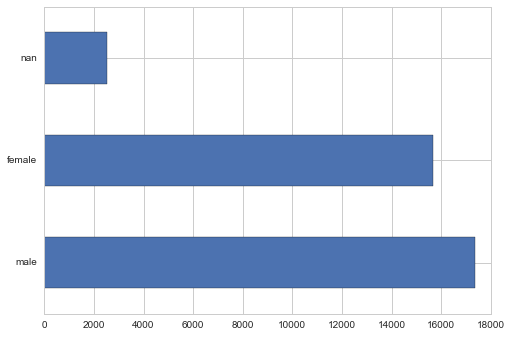

In [12]:
survey_data["sex"].value_counts(dropna=False).plot(kind="barh")

### Solving double entry field by decoupling

When checking the species unique information:

In [13]:
survey_data["species"].unique()

array([nan, 'DM', 'PF', 'PE', 'DM and SH', 'DS', 'PP', 'SH', 'OT', 'DO',
       'OX', 'SS', 'OL', 'RM', 'SA', 'PM', 'AH', 'DX', 'AB', 'CB', 'CM',
       'CQ', 'RF', 'PC', 'PG', 'PH', 'PU', 'CV', 'UR', 'UP', 'ZL', 'UL',
       'CS', 'SC', 'BA', 'SF', 'RO', 'AS', 'SO', 'PI', 'ST', 'CU', 'SU',
       'RX', 'PB', 'PL', 'PX', 'CT', 'US'], dtype=object)

In [14]:
survey_data.head(10)

,record_id,month,day,year,plot,species,verbatimSex,wgt,datasetName,sex
0,1,7,16,1977,2,NaN,M,NaN,Ecological Archives E090-118-D1.,male
1,2,7,16,1977,3,NaN,M,NaN,Ecological Archives E090-118-D1.,male
2,3,7,16,1977,2,DM,F,NaN,Ecological Archives E090-118-D1.,female
3,4,7,16,1977,7,DM,M,NaN,Ecological Archives E090-118-D1.,male
4,5,7,16,1977,3,DM,M,NaN,Ecological Archives E090-118-D1.,male
5,6,7,16,1977,1,PF,M,NaN,Ecological Archives E090-118-D1.,male
6,7,7,16,1977,2,PE,F,NaN,Ecological Archives E090-118-D1.,female
7,8,7,16,1977,1,DM,M,NaN,Ecological Archives E090-118-D1.,male
8,9,7,16,1977,1,DM and SH,NaN,NaN,Ecological Archives E090-118-D1.,NaN
9,10,7,16,1977,6,PF,F,NaN,Ecological Archives E090-118-D1.,female


There apparently exists a double entry: `'DM and SH'`, which basically defines two records and should be decoupled to two individual records (i.e. rows). Hence, we should be able to create a additional row based on this split. To do so, an custom written function is available, called `solve_double_field_entry`:

In [15]:
def solve_double_field_entry(df, keyword="and", column="verbatimEventDate"):
    """split on keyword in column for an enumeration and create extra record
    
    Parameters
    ----------
    df: pd.DataFrame
        DataFrame with a double field entry in one or more values
    keyword: str
        word/character to split the double records on
    column: str
        column name to use for the decoupling of the records
    """
    s = df[column].str.split(keyword).apply(pd.Series, 1).stack().str.strip()
    s.index = s.index.droplevel(-1)
    s.name = column
    del df[column]
    return df.join(s)

We can apply this function to get an update of the DataFrame, with the an additional row (occurrence) added by decoupling the specific field:

<div class="alert alert-success">
    <b>EXERCISE</b>: Use the function solve_double_field_entry to create a DataFrame with an additional row, by decoupling the double entries. Save the result as a variable 'survey_data_decoupled'.
</div>

In [16]:
survey_data_decoupled = solve_double_field_entry(survey_data.copy(), "and", column="species") # get help of the function by CTRL + TAB
# REMARK: the copy() statement here (!)

In [17]:
survey_data_decoupled["species"].unique()

array([nan, 'DM', 'PF', 'PE', 'SH', 'DS', 'PP', 'OT', 'DO', 'OX', 'SS',
       'OL', 'RM', 'SA', 'PM', 'AH', 'DX', 'AB', 'CB', 'CM', 'CQ', 'RF',
       'PC', 'PG', 'PH', 'PU', 'CV', 'UR', 'UP', 'ZL', 'UL', 'CS', 'SC',
       'BA', 'SF', 'RO', 'AS', 'SO', 'PI', 'ST', 'CU', 'SU', 'RX', 'PB',
       'PL', 'PX', 'CT', 'US'], dtype=object)

In [18]:
survey_data_decoupled.head(11)

,record_id,month,day,year,plot,verbatimSex,wgt,datasetName,sex,species
0,1,7,16,1977,2,M,NaN,Ecological Archives E090-118-D1.,male,NaN
1,2,7,16,1977,3,M,NaN,Ecological Archives E090-118-D1.,male,NaN
2,3,7,16,1977,2,F,NaN,Ecological Archives E090-118-D1.,female,DM
3,4,7,16,1977,7,M,NaN,Ecological Archives E090-118-D1.,male,DM
4,5,7,16,1977,3,M,NaN,Ecological Archives E090-118-D1.,male,DM
5,6,7,16,1977,1,M,NaN,Ecological Archives E090-118-D1.,male,PF
6,7,7,16,1977,2,F,NaN,Ecological Archives E090-118-D1.,female,PE
7,8,7,16,1977,1,M,NaN,Ecological Archives E090-118-D1.,male,DM
8,9,7,16,1977,1,NaN,NaN,Ecological Archives E090-118-D1.,NaN,DM
8,9,7,16,1977,1,NaN,NaN,Ecological Archives E090-118-D1.,NaN,SH


### Create new occurrence identifier

The `record_id` is no longer a unique identifier after the decoupling of this dataset. We will make a new dataset-specific identifier, by adding a column called `occurrenceID` that takes a new counter as identifier. As a simply and straightforward approach, we will use a new counter for the whole dataset, starting with 1:

In [19]:
np.arange(1, len(survey_data_decoupled) +1, 1)

array([    1,     2,     3, ..., 35548, 35549, 35550])

<div class="alert alert-success">
    <b>EXERCISE</b>: Create a new column with header 'occurrenceID' with the values 1 -> 35550 as field values. Make the maximal value dependent from the total number of values in the data set
</div>

In [20]:
survey_data_decoupled["occurrenceID"] = np.arange(1, len(survey_data_decoupled) +1, 1)

To overcome the confusion on having both a `record_id` and `occurrenceID` field, we will remove the `record_id` term:

In [21]:
survey_data_decoupled = survey_data_decoupled.drop("record_id", axis=1)

In [22]:
survey_data_decoupled.head(10)

,month,day,year,plot,verbatimSex,wgt,datasetName,sex,species,occurrenceID
0,7,16,1977,2,M,NaN,Ecological Archives E090-118-D1.,male,NaN,1
1,7,16,1977,3,M,NaN,Ecological Archives E090-118-D1.,male,NaN,2
2,7,16,1977,2,F,NaN,Ecological Archives E090-118-D1.,female,DM,3
3,7,16,1977,7,M,NaN,Ecological Archives E090-118-D1.,male,DM,4
4,7,16,1977,3,M,NaN,Ecological Archives E090-118-D1.,male,DM,5
5,7,16,1977,1,M,NaN,Ecological Archives E090-118-D1.,male,PF,6
6,7,16,1977,2,F,NaN,Ecological Archives E090-118-D1.,female,PE,7
7,7,16,1977,1,M,NaN,Ecological Archives E090-118-D1.,male,DM,8
8,7,16,1977,1,NaN,NaN,Ecological Archives E090-118-D1.,NaN,DM,9
8,7,16,1977,1,NaN,NaN,Ecological Archives E090-118-D1.,NaN,SH,10


### Converting the date values

In the survey-dataset we received, the `month`, `day`, and `year` columns are containing the information about the date, i.e. `eventDate` in DarwinCore terms. We want this data in a ISO format `YYYY-MM-DD`. A convenvient Pandas function is the usage of `to_datatime`, which provides multiple options to interpret dates. One of thes options is th automatic interpretation of some `typical` words, like `year`, `month` and `day`.

In [23]:
pd.to_datetime(survey_data_decoupled[["year", "month", "day"]])

ValueError: cannot assemble the datetimes: day is out of range for month

This is not working, not all dates can be interpreted... We should get some more information on the reason of the errors. By using the option `coerce`, the problem makers will be labeled as `NaT`. We can count the number of dates that can not be interpreted:

In [26]:
sum(pd.to_datetime(survey_data_decoupled[["year", "month", "day"]], 'coerce').isnull())

136

<div class="alert alert-success">
    <b>EXERCISE</b>: Make a subselection of 'survey_data_decoupled' containing those records that can not correctly be interpreted as date values and save the resulting DataFrame as variable trouble_makers 
</div>

In [27]:
trouble_makers = survey_data_decoupled[pd.to_datetime(survey_data_decoupled[["year", "month", "day"]], 'coerce').isnull()]

Checking some charactersitics of the trouble_makers:

In [28]:
trouble_makers.head()

,month,day,year,plot,verbatimSex,wgt,datasetName,sex,species,occurrenceID
30649,4,31,2000,6,F,19.0,Ecological Archives E090-118-D1.,female,PP,30651
30650,4,31,2000,6,M,32.0,Ecological Archives E090-118-D1.,male,PB,30652
30651,4,31,2000,6,F,30.0,Ecological Archives E090-118-D1.,female,PB,30653
30652,4,31,2000,6,M,20.0,Ecological Archives E090-118-D1.,male,PP,30654
30653,4,31,2000,6,M,24.0,Ecological Archives E090-118-D1.,male,PP,30655


In [29]:
trouble_makers["day"].unique()

array([31])

In [30]:
trouble_makers["month"].unique()

array([4, 9])

In [31]:
trouble_makers["year"].unique()

array([2000])

So, basically the problem is the presence of day `31` during the months April and September of the year 2000. At this moment, we would have to recheck the original data in order to know how issue could be solved. Apparently, there has been a data-entry problem in 2000, making the `31` days during this period should be `30`. It would be optimal to correct this in the source dataset, but for the further exercise, it will be corrected here:

<div class="alert alert-success">
    <b>EXERCISE</b>: Replace in the DataFrame survey_data_decoupled all of the troublemakers `day` values into the value 30
</div>

In [32]:
survey_data_decoupled.loc[pd.to_datetime(survey_data_decoupled[["year", "month", "day"]], 'coerce').isnull(), "day"] = 30

Now, we do the parsing again to create a proper `eventDate` field, containing the dates:

In [33]:
survey_data_decoupled["eventDate"] = pd.to_datetime(survey_data_decoupled[["year", "month", "day"]])

Just let's do a check the amount of data for each year:

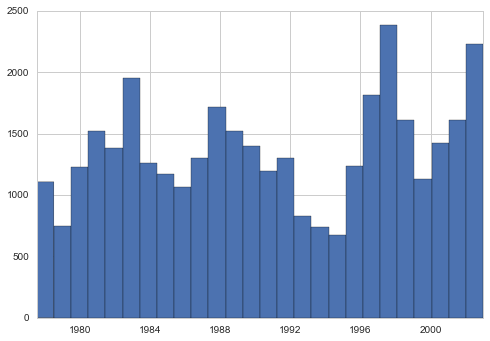

In [34]:
survey_data_decoupled["eventDate"].hist(bins=len(survey_data_decoupled["year"].unique())) # number of bins equal to the number of years

To evaluate the intensity or number of occurrences during different time spans, a heatmap is an interesting representation. This functionality is provided by the plotting library [seaborn](http://seaborn.pydata.org/generated/seaborn.heatmap.html). Let's reformat this data to plot is as a heatmap:

<div class="alert alert-success">
    <b>EXERCISE</b>: Create a table, called `heatmap_prep`, based on `survey_data_decoupled` DataFrame with in the row index the years, in the column the months and as values of the table, the counts for each of these year/month combinations.
</div>

In [45]:
heatmap_prep = survey_data_decoupled.pivot_table(index="year", columns="month", values="occurrenceID", aggfunc='count')

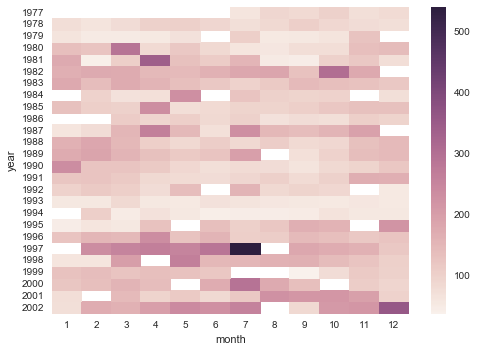

In [46]:
fig, ax = plt.subplots()
ax = sns.heatmap(heatmap_prep)

<div class="alert alert-success">
    <b>EXERCISE</b>: Make a heatmap of the number of records with the days (1 -> 31) in the rows and the months (1 -> 12) in the columns:
</div>

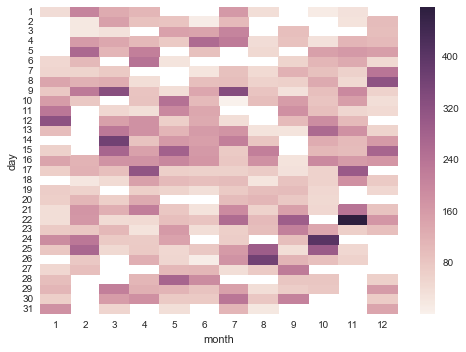

In [47]:
heatmap_prep = survey_data_decoupled.pivot_table(index="day", columns="month", values="occurrenceID", aggfunc='count')
fig, ax = plt.subplots()
ax = sns.heatmap(heatmap_prep)

In [48]:
survey_data_decoupled.head()

,month,day,year,plot,verbatimSex,wgt,datasetName,sex,species,occurrenceID,eventDate
0,7,16,1977,2,M,NaN,Ecological Archives E090-118-D1.,male,NaN,1,1977-07-16
1,7,16,1977,3,M,NaN,Ecological Archives E090-118-D1.,male,NaN,2,1977-07-16
2,7,16,1977,2,F,NaN,Ecological Archives E090-118-D1.,female,DM,3,1977-07-16
3,7,16,1977,7,M,NaN,Ecological Archives E090-118-D1.,male,DM,4,1977-07-16
4,7,16,1977,3,M,NaN,Ecological Archives E090-118-D1.,male,DM,5,1977-07-16


Currently, the dates are stored in a python specific date format:

In [38]:
survey_data_decoupled["eventDate"].dtype

dtype('<M8[ns]')

This is great, because it allows for many functionalities:

In [39]:
survey_data_decoupled.eventDate.dt #add a dot and press TAB to explore the date options it provides 

So, we actually do not need the `day`, `month`, `year` columns anymore and have other options available as well

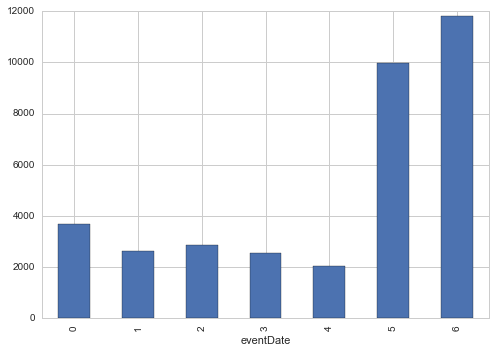

In [40]:
survey_data_decoupled.groupby(survey_data_decoupled["eventDate"].dt.weekday)["occurrenceID"].count().plot(kind="bar")

When saving the information to a file (e.g. CSV-file), this data type will be automatically converted to a string representation. However, we could also decide to explicitly provide the string format the dates are stored (losing the date type functionalities), in order to have full control on the way these dates are formatted:

In [41]:
survey_data_decoupled["eventDate"] = survey_data_decoupled["eventDate"].apply(lambda x: x.strftime('%Y-%m-%d'))

In [42]:
survey_data_decoupled["eventDate"].head()

0    1977-07-16
1    1977-07-16
2    1977-07-16
3    1977-07-16
4    1977-07-16
Name: eventDate, dtype: object

As we do not need the `day`, `month`, `year` columns anymore, we can drop them from the DataFrame:

<div class="alert alert-success">
    <b>EXERCISE</b>: Remove the columns day, month and year from the survey_data_decoupled DataFrame:
</div>

In [43]:
survey_data_decoupled = survey_data_decoupled.drop(["day", "month", "year"], axis=1)

### Provide [weight](http://tdwg.github.io/dwc/terms/#MeasurementOrFact) in appropriate DwC term

The [weights](http://esapubs.org/archive/ecol/E090/118/Portal_rodent_metadata.htm) of the animals are expressed in gram, which can be mapped to the DwC Term [MeasurementOrFact](http://tdwg.github.io/dwc/terms/#MeasurementOrFact). The proposed format is to provide this kind of measured information as a json-string with the following format:

```
{"weight in gram": 200, "length in meter": 0.3,...}
```

We only need to provide weight-information from the `wgt` column:

In [44]:
{"weight in gram": 200}

{'weight in gram': 200}

In [45]:
type({"weight in gram": 200})

dict

Similar to the dates, if we need full control of the way this is represented when saving to a file, we want to store the values as a string inside the fields and not as a dictionary. Python supports the functionalities to convert from and to json-string with the [`json` package](https://docs.python.org/3.5/library/json.html).

In [2]:
import json

In [46]:
json.dumps({"weight in gram": 200})

'{"weight in gram": 200}'

By having a function available that takes such a value together with the string for the key-value and returns the corresponding json string, we can reuse this function for other measurements as well:

In [47]:
def value_to_measurement(value, keystring):
    """convert a value to a json based key-value string
    
    Parameters
    ----------
    value: number
        the measured value
    keystring: str
        the description used as key, describing the property and unit: `property` in `unit`
    """
    if pd.isnull(value):
        return np.nan
    else:
        return json.dumps({keystring: int(value)})

<div class="alert alert-success">
    <b>EXERCISE</b>: Use the function `value_to_measurement` in order to convert the values of the column wgt into a json string and store these values in a new column `measurementOrFact`:
</div>

In [48]:
survey_data_decoupled["measurementOrFact"] = survey_data_decoupled["wgt"].apply(value_to_measurement, args=(["weight in gram"]))

In [49]:
survey_data_decoupled["measurementOrFact"].unique()

array([nan, '{"weight in gram": 40}', '{"weight in gram": 48}',
       '{"weight in gram": 29}', '{"weight in gram": 46}',
       '{"weight in gram": 36}', '{"weight in gram": 52}',
       '{"weight in gram": 8}', '{"weight in gram": 22}',
       '{"weight in gram": 35}', '{"weight in gram": 7}',
       '{"weight in gram": 9}', '{"weight in gram": 42}',
       '{"weight in gram": 41}', '{"weight in gram": 37}',
       '{"weight in gram": 43}', '{"weight in gram": 45}',
       '{"weight in gram": 15}', '{"weight in gram": 39}',
       '{"weight in gram": 30}', '{"weight in gram": 34}',
       '{"weight in gram": 31}', '{"weight in gram": 16}',
       '{"weight in gram": 44}', '{"weight in gram": 20}',
       '{"weight in gram": 33}', '{"weight in gram": 51}',
       '{"weight in gram": 53}', '{"weight in gram": 49}',
       '{"weight in gram": 4}', '{"weight in gram": 50}',
       '{"weight in gram": 19}', '{"weight in gram": 47}',
       '{"weight in gram": 21}', '{"weight in gram": 55

Removing the `wgt` column:

In [50]:
survey_data_decoupled = survey_data_decoupled.drop("wgt", axis=1)

In [51]:
survey_data_decoupled.head()

,plot,sex,datasetName,verbatimSex,species,occurrenceID,eventDate,measurementOrFact
0,2,male,Ecological Archives E090-118-D1.,M,NaN,1,1977-07-16,NaN
1,3,male,Ecological Archives E090-118-D1.,M,NaN,2,1977-07-16,NaN
2,2,female,Ecological Archives E090-118-D1.,F,DM,3,1977-07-16,NaN
3,7,male,Ecological Archives E090-118-D1.,M,DM,4,1977-07-16,NaN
4,3,male,Ecological Archives E090-118-D1.,M,DM,5,1977-07-16,NaN


## Add coordinates from the plot locations

### Loading the coordinate data

The individual plots are only identified by a `plot` identification number. In order to provide sufficient information to external users, additional information about the coordinates should be added. The coordinates of the individual plots are saved in another file: `plot_location.xlsx`. We will use this information to further enrich our dataset and add the Darwin Core Terms `decimalLongitude` and `decimalLatitude`.

<div class="alert alert-success">
    <b>EXERCISE</b>: Read in the excel file 'plot_location.xlsx' and store the data as the variable `plot_data`, with 3 columns: plot, xutm, yutm.
</div>

In [52]:
plot_data = pd.read_excel("../data/plot_location.xlsx", skiprows=3, index_col=0)

In [53]:
plot_data.head()

,plot,xutm,yutm
0,1,681222.131658,3.535262e+06
1,2,681302.799361,3.535268e+06
2,3,681375.294968,3.535270e+06
3,4,681450.837525,3.535271e+06
4,5,681526.983040,3.535281e+06


### Transforming to other coordinate reference system

These coordinates are in meters, more specifically in [UTM 12 N](https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system) coordinate system. However, the agreed coordinate system for Darwin Core is the [World Geodetic System 1984 (WGS84)](http://spatialreference.org/ref/epsg/wgs-84/). 

As this is not a GIS course, we will shortcut the discussion about different projection systems, but provide an example on how such a conversion from UTM12N to WGS84 can be performed with a matplotlib toolkit and by relying on the existing EPSG codes (a registry originally setup by the association of oil & gas producers).

First, we define out two projection systems, using their corresponding EPSG codes:

In [4]:
import mpl_toolkits.basemap as bsmp

In [54]:
utm12n = bsmp.pyproj.Proj("+init=EPSG:32612")
wgs84 = bsmp.pyproj.Proj("+init=EPSG:4326")

The reprojection can be done by the function `transform` of the projection toolkit, providing the coordinate systems and a set of x, y coordinates. For example, for a single coordinate, this can be applied as follows:

In [55]:
bsmp.pyproj.transform(utm12n, wgs84, 681222.131658, 3.535262e+06)

(-109.082829023178, 31.9388498837202)

Instead of writing a `for` loop to do this for each of the coordinates in the list, we can apply this function to each of them:

<div class="alert alert-success">
    <b>EXERCISE</b>: Apply the function `transform` to plot_data, using the columns 'xutm' and 'yutm' and save the resulting output in 2 new columns, called `decimalLongitude` and `decimalLatitude`.
</div>

In [56]:
plot_data[["decimalLongitude" ,"decimalLatitude"]] = plot_data[['xutm', 'yutm']].apply(lambda x : pd.Series(bsmp.pyproj.transform(utm12n, wgs84, x[0], x[1])), axis=1)

In [57]:
plot_data.head()

,plot,xutm,yutm,decimalLongitude,decimalLatitude
0,1,681222.131658,3.535262e+06,-109.082829,31.938851
1,2,681302.799361,3.535268e+06,-109.081975,31.938887
2,3,681375.294968,3.535270e+06,-109.081208,31.938896
3,4,681450.837525,3.535271e+06,-109.080409,31.938894
4,5,681526.983040,3.535281e+06,-109.079602,31.938970


### Checking the coordinates on a map

To check the transformation, let's put these on an interactive map. [Leaflet](http://leafletjs.com/) is a famous service for this and in many programming languages wrappers do exist to simplify the usage. [Folium](https://github.com/python-visualization/folium) is an extensive library providing multiple options. AS we just want to do a quick checkup of the coorindates, we will rely on the package [mplleaflet](https://github.com/jwass/mplleaflet), which just converts a matplotlib image to a leaflet map:

In [58]:
import mplleaflet  # https://github.com/jwass/mplleaflet

In [59]:
fig, ax = plt.subplots(figsize=(5, 8))
plt.plot(plot_data['decimalLongitude'], plot_data['decimalLatitude'], 'rs')

mplleaflet.display(fig=fig)

### Join the coordinate information to the survey data set

All points are inside the desert region as we expected, so we can extend our survey dataset with this coordinate information. Making the combination of two data sets based on a common identifier is completely similar to the usage of `JOIN` operations in databases. In Pandas, this functionality is [`pd.merge`](http://pandas.pydata.org/pandas-docs/stable/merging.html#database-style-dataframe-joining-merging). 

In practice, we have to add the columns `decimalLongitude`/`decimalLatitude` to the current dataset `survey_data_decoupled`, by using the plot identification number as key to join. 

<div class="alert alert-success">
    <b>EXERCISE</b>: Extract only the columns to join to our survey dataset: the plot identifiers, decimalLatitude and decimalLongitude into a variable named plot_data_selection
</div>

In [60]:
plot_data_selection = plot_data[["plot", "decimalLongitude", "decimalLatitude"]]

<div class="alert alert-success">
    <b>EXERCISE</b>: Based on the documentation of pandas merge, add the coordinate information (plot_data_selection) to the survey data set
</div>

In [61]:
survey_data_plots = pd.merge(survey_data_decoupled, plot_data_selection, how="left", on="plot")

In [62]:
survey_data_plots.head()

,plot,sex,datasetName,verbatimSex,species,occurrenceID,eventDate,measurementOrFact,decimalLongitude,decimalLatitude
0,2,male,Ecological Archives E090-118-D1.,M,NaN,1,1977-07-16,NaN,-109.081975,31.938887
1,3,male,Ecological Archives E090-118-D1.,M,NaN,2,1977-07-16,NaN,-109.081208,31.938896
2,2,female,Ecological Archives E090-118-D1.,F,DM,3,1977-07-16,NaN,-109.081975,31.938887
3,7,male,Ecological Archives E090-118-D1.,M,DM,4,1977-07-16,NaN,-109.082816,31.938113
4,3,male,Ecological Archives E090-118-D1.,M,DM,5,1977-07-16,NaN,-109.081208,31.938896


The plot locations need to be stored with the variable name `verbatimLocality` indicating {"plot": plotid}, with plotid, the integer value of the plot:

<div class="alert alert-success">
    <b>EXERCISE</b>: Create the column `verbatimLocality` from the column `plot` by converting the values of the plot identifier to a json string with the format {"plot": ID}:
</div>

In [63]:
survey_data_plots["verbatimLocality"] = survey_data_plots["plot"].apply(value_to_measurement, args=(["plot"]))
survey_data_plots = survey_data_plots.drop("plot", axis=1)

In [64]:
survey_data_plots.head()

,sex,datasetName,verbatimSex,species,occurrenceID,eventDate,measurementOrFact,decimalLongitude,decimalLatitude,verbatimLocality
0,male,Ecological Archives E090-118-D1.,M,NaN,1,1977-07-16,NaN,-109.081975,31.938887,"{""plot"": 2}"
1,male,Ecological Archives E090-118-D1.,M,NaN,2,1977-07-16,NaN,-109.081208,31.938896,"{""plot"": 3}"
2,female,Ecological Archives E090-118-D1.,F,DM,3,1977-07-16,NaN,-109.081975,31.938887,"{""plot"": 2}"
3,male,Ecological Archives E090-118-D1.,M,DM,4,1977-07-16,NaN,-109.082816,31.938113,"{""plot"": 7}"
4,male,Ecological Archives E090-118-D1.,M,DM,5,1977-07-16,NaN,-109.081208,31.938896,"{""plot"": 3}"


## Add species names to dataset

The column `species` only provides a short identifier in the survey overview. The name information is stored in a separate file `species.csv`. As we want our dataset to include this information, we will read in this data and add it to our survey dataset:

<div class="alert alert-success">
    <b>EXERCISE</b>: Read in the 'species.csv' file and save the resulting DataFrame as variable `species_data`
</div>

In [65]:
species_data = pd.read_csv("../data/species.csv", sep=";")

In [66]:
species_data.head()

,species_id,genus,species,taxa
0,AB,Amphispiza,bilineata,Bird
1,AH,Ammospermophilus,harrisi,Rodent-not censused
2,AS,Ammodramus,savannarum,Bird
3,BA,Baiomys,taylori,Rodent
4,CB,Campylorhynchus,brunneicapillus,Bird


### Fix a wrong acronym naming

When reviewing the metadata, you see that in the data-file the acronym `NE` is used to describe `Neotoma albigula`, whereas in the [metadata description](http://esapubs.org/archive/ecol/E090/118/Portal_rodent_metadata.htm), the acronym `NA` is used. 

<div class="alert alert-success">
    <b>EXERCISE</b>: Convert the value of NE to NA by using boolean indexing
</div>

In [67]:
species_data.loc[species_data["species_id"] == "NE", "species_id"] = "NA"

(At the same time, you decide to cure this problem at the source and alerts the data provider about this issue.)

### Merging surveys and species

As we now prepared the two series, we can combine the data, using the `merge` operation. Take into account that our key-column is different for `species_data` and `survey_data_plots`, respectively `species_id` and `species`:

We want to add the data of the species to the survey data, in order to see the full species names:

<div class="alert alert-success">
    <b>EXERCISE</b>: Merge the `survey_data_plots` data set with the `species_data` information in order to ass the species information to the survey data:
</div>

In [75]:
survey_data_species = pd.merge(survey_data_plots, species_data, how="left",  # LEFT OR INNER?
                                left_on="species", right_on="species_id")

In [76]:
len(survey_data_species)

35550

The join is ok, but we are left with some redundant columns and wrong naming:

In [77]:
 survey_data_species.head()

,sex,datasetName,verbatimSex,species_x,occurrenceID,eventDate,measurementOrFact,decimalLongitude,decimalLatitude,verbatimLocality,species_id,genus,species_y,taxa
0,male,Ecological Archives E090-118-D1.,M,NaN,1,1977-07-16,NaN,-109.081975,31.938887,"{""plot"": 2}",NaN,NaN,NaN,NaN
1,male,Ecological Archives E090-118-D1.,M,NaN,2,1977-07-16,NaN,-109.081208,31.938896,"{""plot"": 3}",NaN,NaN,NaN,NaN
2,female,Ecological Archives E090-118-D1.,F,DM,3,1977-07-16,NaN,-109.081975,31.938887,"{""plot"": 2}",DM,Dipodomys,merriami,Rodent
3,male,Ecological Archives E090-118-D1.,M,DM,4,1977-07-16,NaN,-109.082816,31.938113,"{""plot"": 7}",DM,Dipodomys,merriami,Rodent
4,male,Ecological Archives E090-118-D1.,M,DM,5,1977-07-16,NaN,-109.081208,31.938896,"{""plot"": 3}",DM,Dipodomys,merriami,Rodent


We do not need the columns `species_x` and `species_id` column anymore, as we will use the scientific names from now on:

In [78]:
survey_data_species = survey_data_species.drop(["species_x", "species_id"], axis=1)

The column `species_y` could just be names `species`:

In [79]:
survey_data_species = survey_data_species.rename(columns={"species_y": "species"})

In [80]:
survey_data_species.head()

,sex,datasetName,verbatimSex,occurrenceID,eventDate,measurementOrFact,decimalLongitude,decimalLatitude,verbatimLocality,genus,species,taxa
0,male,Ecological Archives E090-118-D1.,M,1,1977-07-16,NaN,-109.081975,31.938887,"{""plot"": 2}",NaN,NaN,NaN
1,male,Ecological Archives E090-118-D1.,M,2,1977-07-16,NaN,-109.081208,31.938896,"{""plot"": 3}",NaN,NaN,NaN
2,female,Ecological Archives E090-118-D1.,F,3,1977-07-16,NaN,-109.081975,31.938887,"{""plot"": 2}",Dipodomys,merriami,Rodent
3,male,Ecological Archives E090-118-D1.,M,4,1977-07-16,NaN,-109.082816,31.938113,"{""plot"": 7}",Dipodomys,merriami,Rodent
4,male,Ecological Archives E090-118-D1.,M,5,1977-07-16,NaN,-109.081208,31.938896,"{""plot"": 3}",Dipodomys,merriami,Rodent


In [304]:
len(survey_data_species)

35550

## (OPTIONAL SECTION) Using a API service to match the scientific names

As the current species names are rather short and could eventually lead to confusion when shared with other users, retrieving additional information about the different species in our dataset would be useful to integrate our work with other research. An option is to mathc our names with an external service to request additional information about the different species.

One of these services is [GBIF API](http://www.gbif.org/developer/species). The service can most easily be illustrated with a small example:<br><br>
In a new tabblad of the browser, go to the URL [http://www.gbif.org/species/2475532](http://www.gbif.org/species/2475532), which corresponds to the page of `Alcedo atthis` (*ijsvogel* in dutch). One could for each of the species in the list we have do a search on the website of GBIF to find the corresponding page of the different species, from which more information can be extracted manually. However, this would take a lot of time...

Therefore, GBIF (and many other organisations!) provides a service to extract the same information on a machine-readable way, in order to automate these searches. As an example, let's search for the information of `Alcedo atthis`, using the GBIF API: Go to the URL: [http://api.gbif.org/v1/species/match?name=Alcedo atthis](http://api.gbif.org/v1/species/match?name=%22Alcedo%20atthis%22) and check the output. What we did is a machine-based search on the GBIF website for information about `Alcedo atthis`.

The same can be done using Python. The main library we need to this kind of automated searches is the [`request` package](http://docs.python-requests.org/en/master/), which can be used to do request to any kind of API out there.

In [3]:
import requests

### Example matching with Alcedo Atthis

For the example of `Alcedo atthis`:

In [302]:
species_name = 'Alcedo atthis'

In [303]:
base_string = 'http://api.gbif.org/v1/species/match?'
request_parameters = {'verbose': False, 'strict': True, 'name': species_name}
message = requests.get(base_string, params=request_parameters).json()
message

{'canonicalName': 'Alcedo atthis',
 'class': 'Aves',
 'classKey': 212,
 'confidence': 99,
 'family': 'Alcedinidae',
 'familyKey': 2984,
 'genus': 'Alcedo',
 'genusKey': 2475493,
 'kingdom': 'Animalia',
 'kingdomKey': 1,
 'matchType': 'EXACT',
 'order': 'Coraciiformes',
 'orderKey': 1447,
 'phylum': 'Chordata',
 'phylumKey': 44,
 'rank': 'SPECIES',
 'scientificName': 'Alcedo atthis (Linnaeus, 1758)',
 'species': 'Alcedo atthis',
 'speciesKey': 2475532,
 'status': 'ACCEPTED',
 'synonym': False,
 'usageKey': 2475532}

From which we get a dictionary containing more information about the taxonomy of the `Alcedo atthis`.

In the species data set available, the name to match is provided in the combination of two columns, so we have to combine those to in order to execute the name matching:

In [258]:
genus_name = "Callipepla"
species_name = "squamata"
name_to_match = '{} {}'.format(genus_name, species_name)
base_string = 'http://api.gbif.org/v1/species/match?'
request_parameters = {'strict': True, 'name': name_to_match} # use strict matching(!)
message = requests.get(base_string, params=request_parameters).json()
message

{'canonicalName': 'Callipepla squamata',
 'class': 'Aves',
 'classKey': 212,
 'confidence': 99,
 'family': 'Odontophoridae',
 'familyKey': 9325,
 'genus': 'Callipepla',
 'genusKey': 2474205,
 'kingdom': 'Animalia',
 'kingdomKey': 1,
 'matchType': 'EXACT',
 'order': 'Galliformes',
 'orderKey': 723,
 'phylum': 'Chordata',
 'phylumKey': 44,
 'rank': 'SPECIES',
 'scientificName': 'Callipepla squamata (Vigors, 1830)',
 'species': 'Callipepla squamata',
 'speciesKey': 5228075,
 'status': 'ACCEPTED',
 'synonym': False,
 'usageKey': 5228075}

To apply this on our species data set, we will have to do this request for each of the individual species/genus combination. As, this is a returning functionality, we will write a small function to do this:

### Writing a custom matching function

<div class="alert alert-success">
    <b>EXERCISE</b>: Write a function, called `name_match` that takes the `genus`, the `species` and the option to perform a strict matching or not as inputs, performs a matching with the GBIF name matching API and return the received message as a dictionary.
</div>

In [259]:
def name_match(name, strict=True):
    """
    Perform a GBIF name matching using the species and genus names
    
    Parameters
    ----------
    species_name: str
        name of the species to request more information
    genus_name: str
        name of the genus of the species
    strict: boolean
        define if the mathing need to be performed with the strict option (True) or not (False)
    
    Returns
    -------
    message: dict
        dictionary with the information returned by the GBIF matching service
    """
    base_string = 'http://api.gbif.org/v1/species/match?'
    request_parameters = {'strict': strict, 'name': name} # use strict matching(!)
    message = requests.get(base_string, params=request_parameters).json()
    return message

<div class="alert alert-danger">
    <b>NOTE</b>: For many of these API request handling, dedicated packages do exist, e.g. [pygbif](https://github.com/sckott/pygbif) provides different functions to do requests to the GBIF API, basically wrapping the request possibilities. For any kind of service, just ask yourself: is the dedicated library providing sufficient additional advantage, or can I easily setup the request myself. (or sometimes: for which the documentation is the best...)<br><br>Many services do exist for a wide range of applications, e.g. scientific name matching, matching of addresses, downloading of data,...
</div>

Testing our custom matching function:

In [262]:
genus_name = "Callipepla"
species_name = "squamata"
name_match('{} {}'.format(genus_name, species_name), strict=True)

{'canonicalName': 'Callipepla squamata',
 'class': 'Aves',
 'classKey': 212,
 'confidence': 99,
 'family': 'Odontophoridae',
 'familyKey': 9325,
 'genus': 'Callipepla',
 'genusKey': 2474205,
 'kingdom': 'Animalia',
 'kingdomKey': 1,
 'matchType': 'EXACT',
 'order': 'Galliformes',
 'orderKey': 723,
 'phylum': 'Chordata',
 'phylumKey': 44,
 'rank': 'SPECIES',
 'scientificName': 'Callipepla squamata (Vigors, 1830)',
 'species': 'Callipepla squamata',
 'speciesKey': 5228075,
 'status': 'ACCEPTED',
 'synonym': False,
 'usageKey': 5228075}

However, the matching won't provide an answer for every search:

In [263]:
genus_name = "Lizard"
species_name = "sp."
name_match('{} {}'.format(genus_name, species_name), strict=True)

{'confidence': 100, 'matchType': 'NONE', 'synonym': False}

### Match each of the species names of the survey data set

Hence, in order to add this information to our survey DataFrame, we need to perform the following steps:
1. extract the unique genus/species combinations in our dataset and combine them in single column
2. match each of these names to the GBIF API service
3. process the returned message:
    * if a match is found, add the information of the columns 'class', 'kingdom', 'order', 'phylum', 'scientificName', 'status' and 'usageKey'
    * if no match was found: nan-values
4. Join the DataFrame of unique genus/species information with the enriched GBIF info to the `survey_data_species` data set

<div class="alert alert-success">
    <b>EXERCISE</b>: Extract the unique combinations of genus and species in the `survey_data_species` using the function `drop_duplicates()`. Save the result as the variable `unique_species`
</div>

In [264]:
%%timeit
unique_species = survey_data_species[["genus", "species"]].drop_duplicates().dropna()

100 loops, best of 3: 4.78 ms per loop


In [265]:
len(unique_species)

47

<div class="alert alert-success">
    <b>EXERCISE</b>: Extract the unique combinations of genus and species in the `survey_data_species` using `groupby`. Save the result as the variable `unique_species`
</div>

In [267]:
%%timeit
unique_species = survey_data_species.groupby(["genus", "species"]).first().reset_index()[["genus", "species"]]

10 loops, best of 3: 23 ms per loop


In [268]:
len(unique_species)

47

<div class="alert alert-success">
    <b>EXERCISE</b>: Combine the columns genus and species to a single column with the complete name, save it in a new column named 'name'
</div>

In [278]:
unique_species["name"] = unique_species["genus"] + " " + unique_species["species"] 
# an alternative approach worthwhile to know:
#unique_species["name"] = unique_species["genus"].str.cat(unique_species["species"], " ")

In [279]:
unique_species.head()

,genus,species,name
0,Ammodramus,savannarum,Ammodramus savannarum
1,Ammospermophilus,harrisi,Ammospermophilus harrisi
2,Amphispiza,bilineata,Amphispiza bilineata
3,Baiomys,taylori,Baiomys taylori
4,Calamospiza,melanocorys,Calamospiza melanocorys


To perform the matching for each of the combination, different options do exist. 

Just to show the possibility of using `for` loops, the addition of the matched information will be done as such. First, we will store everything in one dictionary, where the keys of the dictionary are the index values of `unique_species` (in order to later merge them again) and the values are the entire messages (which are dictionaries aon itself). The format will look as following: 

```
species_annotated = {O: {'canonicalName': 'Squamata', 'class': 'Reptilia', 'classKey': 358, ...}, 
                     1: {'canonicalName':...},
                     2:...}
```

In [280]:
species_annotated = {}
for key, row in unique_species.iterrows():
    species_annotated[key] = name_match(row["name"], strict=True)

In [281]:
 species_annotated

{0: {'canonicalName': 'Ammodramus savannarum',
  'class': 'Aves',
  'classKey': 212,
  'confidence': 99,
  'family': 'Emberizidae',
  'familyKey': 9608,
  'genus': 'Ammodramus',
  'genusKey': 2491079,
  'kingdom': 'Animalia',
  'kingdomKey': 1,
  'matchType': 'EXACT',
  'order': 'Passeriformes',
  'orderKey': 729,
  'phylum': 'Chordata',
  'phylumKey': 44,
  'rank': 'SPECIES',
  'scientificName': 'Ammodramus savannarum (J. F. Gmelin, 1789)',
  'species': 'Ammodramus savannarum',
  'speciesKey': 2491123,
  'status': 'ACCEPTED',
  'synonym': False,
  'usageKey': 2491123},
 1: {'canonicalName': 'Ammospermophilus harrisii',
  'class': 'Mammalia',
  'classKey': 359,
  'confidence': 96,
  'family': 'Sciuridae',
  'familyKey': 9456,
  'genus': 'Ammospermophilus',
  'genusKey': 2437567,
  'kingdom': 'Animalia',
  'kingdomKey': 1,
  'matchType': 'FUZZY',
  'order': 'Rodentia',
  'orderKey': 1459,
  'phylum': 'Chordata',
  'phylumKey': 44,
  'rank': 'SPECIES',
  'scientificName': 'Ammospermophil

We can now easily transform this to a pandas DataFrame:

<div class="alert alert-success">
    <b>EXERCISE</b>: Convert the dictionary `species_annotated` into a pandas DataFrame with the row index the key-values corresponding to `unique_species` and the column headers the output columns of the API response. Save the result as the variable df_species_annotated.
</div>

In [282]:
df_species_annotated = pd.DataFrame(species_annotated).transpose()

In [285]:
df_species_annotated.head()

,canonicalName,class,classKey,confidence,family,familyKey,genus,genusKey,kingdom,kingdomKey,...,orderKey,phylum,phylumKey,rank,scientificName,species,speciesKey,status,synonym,usageKey
0,Ammodramus savannarum,Aves,212,99,Emberizidae,9608,Ammodramus,2491079,Animalia,1,...,729,Chordata,44,SPECIES,"Ammodramus savannarum (J. F. Gmelin, 1789)",Ammodramus savannarum,2491123,ACCEPTED,False,2491123
1,Ammospermophilus harrisii,Mammalia,359,96,Sciuridae,9456,Ammospermophilus,2437567,Animalia,1,...,1459,Chordata,44,SPECIES,"Ammospermophilus harrisii (Audubon & Bachman, ...",Ammospermophilus harrisii,2437568,ACCEPTED,False,2437568
2,Amphispiza bilineata,Aves,212,99,Emberizidae,9608,Amphispiza,2491750,Animalia,1,...,729,Chordata,44,SPECIES,"Amphispiza bilineata (Cassin, 1850)",Amphispiza bilineata,2491757,ACCEPTED,False,2491757
3,Baiomys taylori,Mammalia,359,99,Cricetidae,3240723,Baiomys,2438864,Animalia,1,...,1459,Chordata,44,SPECIES,"Baiomys taylori (Thomas, 1887)",Baiomys taylori,2438866,ACCEPTED,False,2438866
4,Calamospiza melanocorys,Aves,212,99,Emberizidae,9608,Calamospiza,2491892,Animalia,1,...,729,Chordata,44,SPECIES,"Calamospiza melanocorys Stejneger, 1885",Calamospiza melanocorys,2491893,ACCEPTED,False,2491893


### Select relevant information and add this to the survey data

<div class="alert alert-success">
    <b>EXERCISE</b>: Subselect the columns 'class', 'kingdom', 'order', 'phylum', 'scientificName', 'status' and  'usageKey' from the DataFrame `df_species_annotated`. Save it as the variable `df_species_annotated_subset`
</div>

In [286]:
df_species_annotated_subset = df_species_annotated[['class', 'kingdom', 'order', 'phylum', 'scientificName', 'status', 'usageKey']]

In [288]:
df_species_annotated_subset.head()

,class,kingdom,order,phylum,scientificName,status,usageKey
0,Aves,Animalia,Passeriformes,Chordata,"Ammodramus savannarum (J. F. Gmelin, 1789)",ACCEPTED,2491123
1,Mammalia,Animalia,Rodentia,Chordata,"Ammospermophilus harrisii (Audubon & Bachman, ...",ACCEPTED,2437568
2,Aves,Animalia,Passeriformes,Chordata,"Amphispiza bilineata (Cassin, 1850)",ACCEPTED,2491757
3,Mammalia,Animalia,Rodentia,Chordata,"Baiomys taylori (Thomas, 1887)",ACCEPTED,2438866
4,Aves,Animalia,Passeriformes,Chordata,"Calamospiza melanocorys Stejneger, 1885",ACCEPTED,2491893


<div class="alert alert-success">
    <b>EXERCISE</b>: Join the df_species_annotated_subset information to the `unique_species` overview of species. Save the result as variable 'unique_species_annotated':
</div>

In [292]:
unique_species_annotated = pd.merge(unique_species, df_species_annotated_subset, left_index=True, right_index=True)

<div class="alert alert-success">
    <b>EXERCISE</b>: Add the `unique_species_annotated` data to the `survey_data_species` data set, using both the genus and species column as keys. Save the result as the variable `survey_data_completed`.
</div>

In [307]:
survey_data_completed = pd.merge(survey_data_species, unique_species_annotated, how='left', on= ["genus", "species"])

In [309]:
len(survey_data_completed)

35550

In [311]:
survey_data_completed.head()

,sex,datasetName,verbatimSex,occurrenceID,eventDate,measurementOrFact,decimalLongitude,decimalLatitude,verbatimLocality,genus,species,taxa,name,class,kingdom,order,phylum,scientificName,status,usageKey
0,male,Ecological Archives E090-118-D1.,M,1,1977-07-16,NaN,-109.081975,31.938887,"{""plot"": 2}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,male,Ecological Archives E090-118-D1.,M,2,1977-07-16,NaN,-109.081208,31.938896,"{""plot"": 3}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,female,Ecological Archives E090-118-D1.,F,3,1977-07-16,NaN,-109.081975,31.938887,"{""plot"": 2}",Dipodomys,merriami,Rodent,Dipodomys merriami,Mammalia,Animalia,Rodentia,Chordata,"Dipodomys merriami Mearns, 1890",ACCEPTED,2439521
3,male,Ecological Archives E090-118-D1.,M,4,1977-07-16,NaN,-109.082816,31.938113,"{""plot"": 7}",Dipodomys,merriami,Rodent,Dipodomys merriami,Mammalia,Animalia,Rodentia,Chordata,"Dipodomys merriami Mearns, 1890",ACCEPTED,2439521
4,male,Ecological Archives E090-118-D1.,M,5,1977-07-16,NaN,-109.081208,31.938896,"{""plot"": 3}",Dipodomys,merriami,Rodent,Dipodomys merriami,Mammalia,Animalia,Rodentia,Chordata,"Dipodomys merriami Mearns, 1890",ACCEPTED,2439521


## Acknowledgements

* `species.csv` and `survey.csv` are used from the [data carpentry workshop](https://github.com/datacarpentry/python-ecology-lesson) This data is from the paper S. K. Morgan Ernest, Thomas J. Valone, and James H.
Brown. 2009. Long-term monitoring and experimental manipulation of a Chihuahuan Desert ecosystem near Portal, Arizona, USA. Ecology 90:1708. http://esapubs.org/archive/ecol/E090/118/
* The `plot_location.xlsx` is a dummy created location file purely created for this exercise, using the plots location on google maps